In [1]:
cd ../../..

/home/msi/projects/diplomka


In [2]:
import pandas as pd
import glob
from datetime import datetime, timedelta
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import count

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")

# Get files

In [28]:
# files = sorted(glob.glob("data/sites/CA_SFU_T2-CSCS_LCG2/*.json"))
files = sorted(glob.glob("data/sites/FZK_LCCG2-INFN_T1/*.json"))
len(files)

59591

In [29]:
file_iter = iter(files)

# Graph

In [30]:
g: nx.DiGraph = nx.DiGraph()

In [31]:
def init_statistics(u, v, ts, mu, sigma=1, alpha_0=1, beta_0=1):
    edge_attributes: dict = g.edges[(u, v)]
    edge_attributes["alphas"] = [alpha_0]
    edge_attributes["betas"] = [beta_0]
    edge_attributes["n"] = [1]
    edge_attributes["mu"] = [mu]
    edge_attributes["sigmas"] = [sigma]
    edge_attributes["timestamps"] = [ts]
    edge_attributes["rtt"] = [mu]


In [32]:
evaluation_df = pd.DataFrame(columns=["src_node", "dest_node", "mu", "sigma", "delta_rtt", "ts", "trace_id"])

In [33]:
evaluation_df

,src_node,dest_node,mu,sigma,delta_rtt,ts,trace_id


In [34]:
def update_statistics(u, v, ts, delta_rtt, trace_id):
    edge_attributes = g.edges[(u, v)]

    n = edge_attributes["n"]
    mu =  edge_attributes["mu"]
    alphas = edge_attributes["alphas"]
    betas =  edge_attributes["betas"]
    sigmas = edge_attributes["sigmas"]
    timesamps = edge_attributes["timestamps"]
    rtts = edge_attributes["rtt"]

    timesamps.append(ts)
    rtts.append(delta_rtt)

    alphas.append(alphas[-1] + 1/2)
    n.append(n[-1] + 1)

    betas.append(betas[-1] + 0.5*(delta_rtt-mu[-1])**2)
    mu.append(mu[-1] + 1/(n[-1]+1) * (delta_rtt-mu[-1]))
    std = math.sqrt(betas[-1]/(alphas[-1] + 1))
    sigmas.append(std)

    evaluation_df.loc[evaluation_df.shape[0]] = [u, v, mu[-1], std, delta_rtt, ts, trace_id]     # type: ignore
    return mu[-1], std # return mean and variance


In [35]:
def add_node(node, **kwargs):
    global g
    if node not in g:
        g.add_node(node, ctr=1, **kwargs)
    else:
        # increment the number of times we have seen this node
        g.nodes[node]["ctr"]+=1
        # add the attributes
        for k, v in kwargs.items():
            if k not in g.nodes[node]:
                g.nodes[node][k] = v

In [36]:
def add_edge(src_node, dest_node, ts=None, **kwargs):
    global g
    delta_rtt=kwargs["delta_rtt"]
    # adds the edge in the same way as the add_node function
    if (src_node, dest_node) not in g.edges:
        if "trace_id" in kwargs:
            del kwargs["trace_id"]
        g.add_edge(src_node, dest_node, ctr=1, **kwargs) 
        init_statistics(src_node, dest_node, ts=ts, mu=delta_rtt)
    else:
        g.edges[src_node, dest_node]["ctr"]+=1

        update_statistics(src_node, dest_node, ts=ts, delta_rtt=delta_rtt, trace_id=kwargs["trace_id"])
        for k, v in kwargs.items():
            if k not in g.edges[src_node, dest_node]:
                g.edges[src_node, dest_node][k] = v
            else:
                g.edges[src_node, dest_node][k]+= v

In [58]:
def get_traceroute_prob(src, path):
    probs = []
    curr = src
    node_gen = iter(path)
    while True:
        try:
            target = next(node_gen)
            all_possible = [g.get_edge_data(*edge).get("ctr", 1) for edge in g.out_edges(curr)]
            edge_p = g.get_edge_data(curr, target).get("ctr", 1)
            # print(curr, target, edge_p/sum(all_possible))

            probs.append(edge_p/sum(all_possible))
            curr = target
        except StopIteration:
            break
        except AttributeError:
            # print(curr, target, " not found")
            continue # TODO ???
    return probs


In [59]:
def get_path_prob(src, path):
    all_edge_occurences = [x.get("ctr",1) for u,v,x in g.edges(data=True)]
    path_occurences = 0
    curr = src
    curr_gen = iter(path)
    while True:
        try:
            target = next(curr_gen)
            path_occurences += g.get_edge_data(curr, target).get("ctr", 1)
            curr = target
        except StopIteration:
            break
        except AttributeError:
            # print(curr, target, " not found")
            continue # TODO ???
    return path_occurences/sum(all_edge_occurences)

In [60]:
def get_path_segments(src, path):
    segments = []
    curr = src
    curr_gen = iter(path)
    while True:
        try:
            target = next(curr_gen)
            segments.append((curr, target))
            curr = target
        except StopIteration: 
            break
    return segments

In [61]:
path_stats = pd.DataFrame(columns=["src", "dest", "markov_prob", "path_prob", "expected_rtt", "max_rtt", "trace_id"], index=pd.DatetimeIndex([]))

In [62]:
def evaluate(row, trace_id):
    traceroute_prob = get_traceroute_prob(row["src"], row["hops"])
    markov_prob = math.prod(traceroute_prob)
    path_prob = get_path_prob(row["src"], row["hops"])
    # TODO: calculate sum(p{src-edge} * E[delta_rtt])
    edges = get_path_segments(row["src"], row["hops"])
    
    mus = [g.edges[edge]["mu"][-1] for edge in edges]
    expected_rtt = sum(p*mu for p, mu in zip(traceroute_prob, mus))

    # TODO: create a sequence of belonging to sigma strips (i.e. is greater than 0, 1, 2, 3, 4 strip? => max)
    path_stats.loc[row["timestamp"]] = [row["src"], row["dest"], markov_prob, path_prob, expected_rtt, row["max_rtt"], trace_id]


In [63]:
stat_df = pd.DataFrame({"src":[], "dest":[], "num_nodes":[], "num_edges":[], "max_delta_rtts": [], "max_delta_ttls":[], "n_hops":[], "reached":[], "trace_id":[]}, index=pd.DatetimeIndex([]))
stat_df

,src,dest,num_nodes,num_edges,max_delta_rtts,max_delta_ttls,n_hops,reached,trace_id


In [64]:
trace_id = count(0,1)

In [65]:
a = [2,3,7,12,24,37]

In [66]:
[(x - a[i])  for i,x in enumerate(a[1:])]

[1, 4, 5, 12, 13]

In [67]:
def extract_data_from_traceroute(row):

    global stat_df
    global trace_id

    tid = next(trace_id)
    if not row["n_hops"]:
        return

    src = row["src"]
    dest = row["dest"]
    
    if "src_site" not in row:
        row["src_site"] = "UNKNOWN"
    if "src_VO" not in row:
        row["src_VO"] = "UNKNOWN"

    add_node(src, color='red', **{x: row[f"src_{x}"] for x in ["VO", "host", "production", "site"]})
    add_node(dest, color='green', **{x: row[f"dest_{x}"] for x in ["VO", "host", "production", "site"]})

    # extract delta ttl a rtt
    ttls = row["ttls"] 
    rtts = row["rtts"]
    # TODO predelat differenci
    
    delta_ttls = [x - ttls[i]for i,x in enumerate(ttls[1:])]
    delta_rtts = [(x - rtts[i]) for i,x in enumerate(rtts[1:])]

    ts = pd.to_datetime(row["timestamp"], unit='ms')
    
    # for each edge, update statistics
    curr = src
    for (ip_address, delta_ttl, delta_rtt) in zip(row["hops"], delta_ttls, delta_rtts):
        # add node
        add_node(ip_address)
        add_edge(curr, ip_address, delta_ttl=delta_ttl, delta_rtt=delta_rtt, ts=ts, trace_id=tid)
        curr = ip_address

    # add statistics
    max_delta_ttl = max(delta_ttls) if delta_ttls else 1
    max_delta_rtt = max(delta_rtts) if delta_rtts else 1
    num_hops = row["n_hops"]
    evaluate(row, tid)
    stat_df.loc[ts] = [src, dest, len(g.nodes), len(g.edges), max_delta_rtt, max_delta_ttl, num_hops, row["destination_reached"], tid]

In [68]:
from tqdm import tqdm

In [69]:
g = nx.DiGraph()

In [70]:
g.edges

OutEdgeView([])

In [71]:
for file in tqdm(files[:len(files)]):
    # traceroute = pd.concat( [pd.read_json(next(file_iter), orient='index').T for _ in range(11)],  ignore_index=True)
    # for index, row in traceroute.iterrows():
    df = pd.read_json(file, orient='index').T
    for idx, row in df.iterrows():
        try:
            extract_data_from_traceroute(row)
        except Exception as e:
            pass

  7%|▋         | 3885/59591 [01:00<14:30, 63.97it/s]


KeyboardInterrupt: 

In [72]:
# TODO: calculate average number of neighbors per node
num_neighs = list(map(lambda x: len(list(g.neighbors(x))), g.nodes))

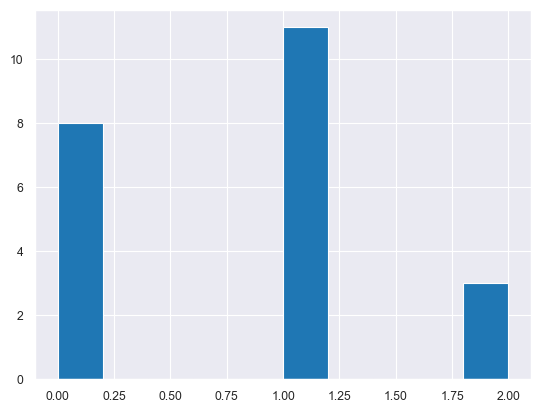

In [73]:
plt.hist(num_neighs);

In [75]:
len(g.nodes)

22

In [76]:
len(g.edges)

17

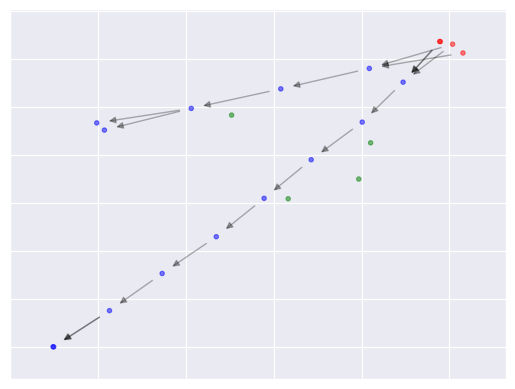

In [77]:
layout = nx.drawing.kamada_kawai_layout(g)
nx.draw_networkx_edges(g, layout, alpha=0.3)
nx.draw_networkx_nodes(g.nodes, layout, node_size=10, node_color=[x.get("color", "blue") for i,x in g.nodes(data=True)], alpha=0.5)
# nx.draw_networkx(g, layout, with_labels=False) # type: ignore
# todo set edge length to mean delta ttl

<Axes: >

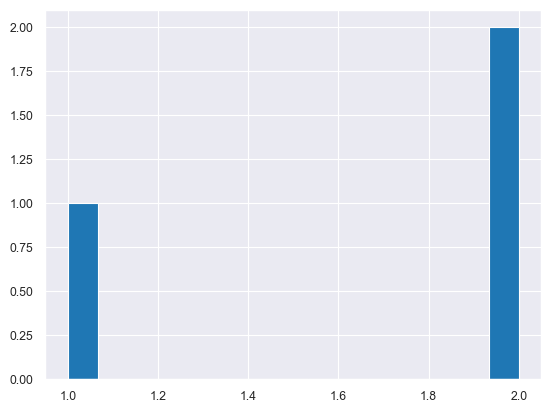

In [78]:
stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).hist(bins=15)

In [79]:
stat_df.index.dtype

dtype('<M8[ns]')

In [80]:
tgt = stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).index

In [81]:
src, dest = list(zip(*tgt.values))

In [82]:
heatmap = pd.DataFrame(index=list(set(src)), columns=list(set(dest)))

In [83]:
for (s, d), x in  stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False, ).items():
    heatmap.loc[s,d] = x

<Axes: >

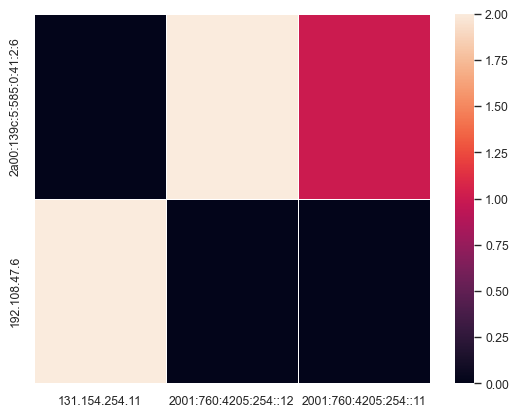

In [84]:
sns.heatmap(heatmap.fillna(0), linewidths=0.5, annot=False, )

In [85]:
# todo pro kazdy segment vzit v jakem pasu je [0, 1, .., 4] a spocitat prumer nebo median

In [86]:
evaluation_df.index.dtype

dtype('int64')

In [87]:
evaluation_df.index = pd.to_datetime(evaluation_df.index, unit='ms')

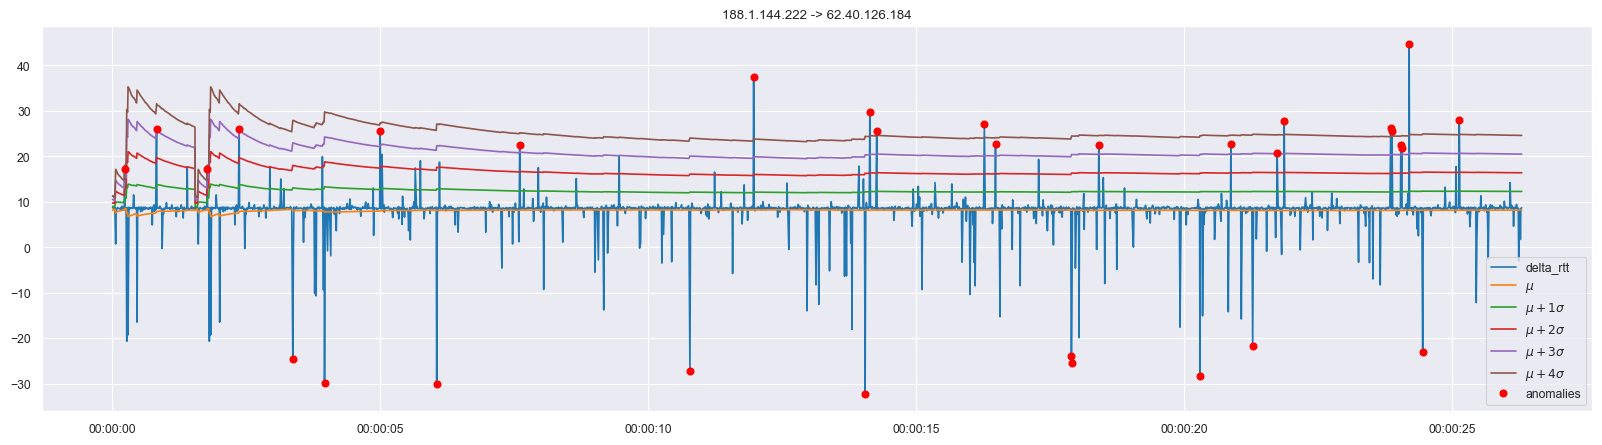

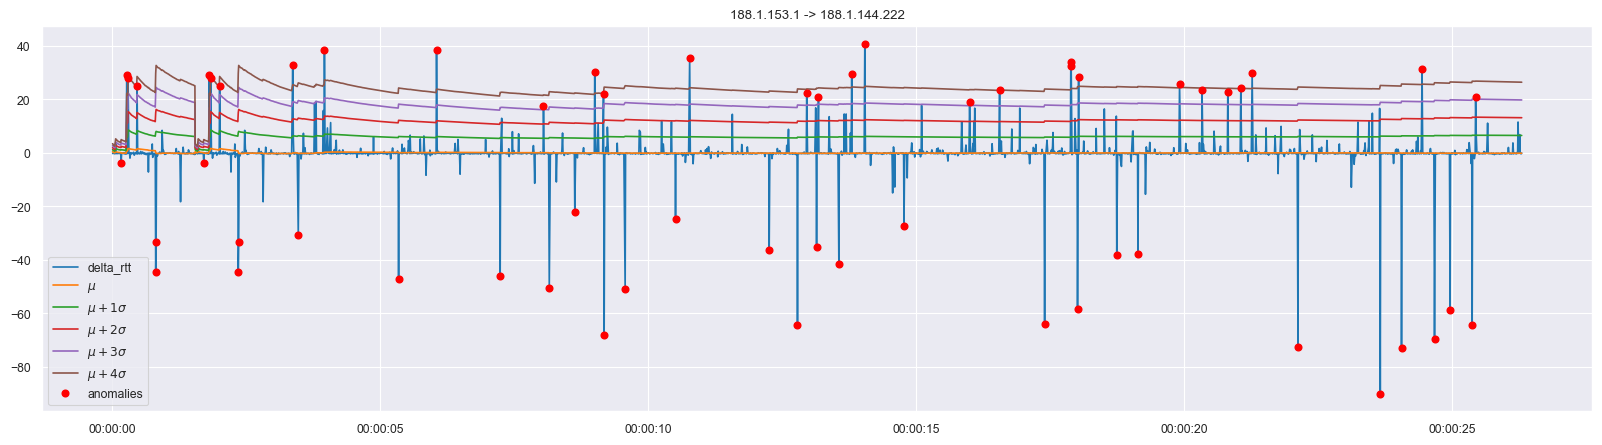

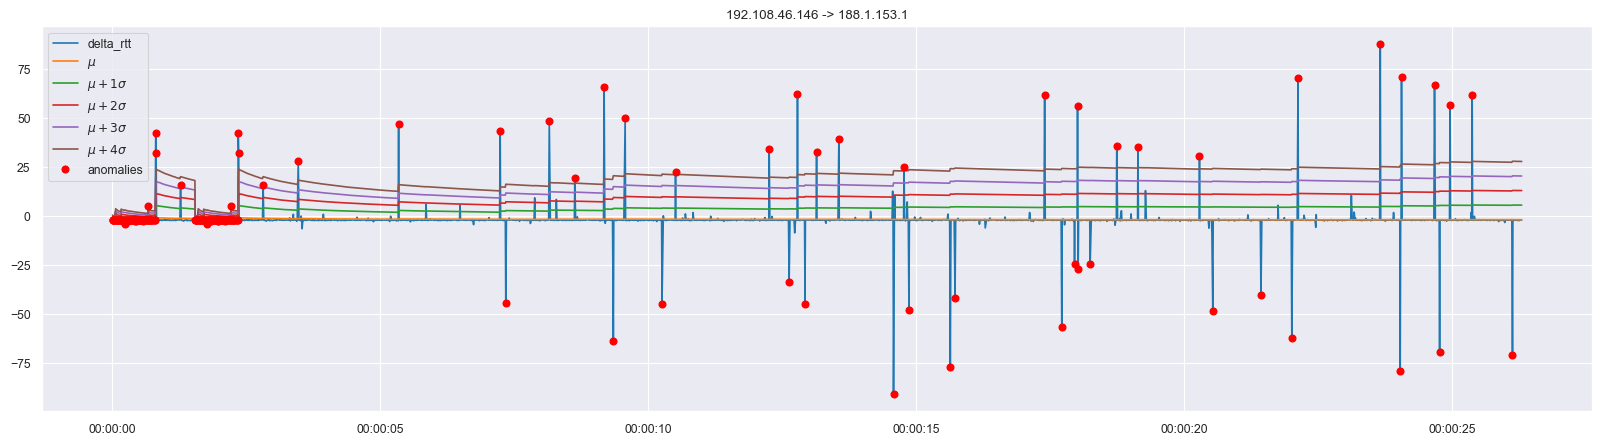

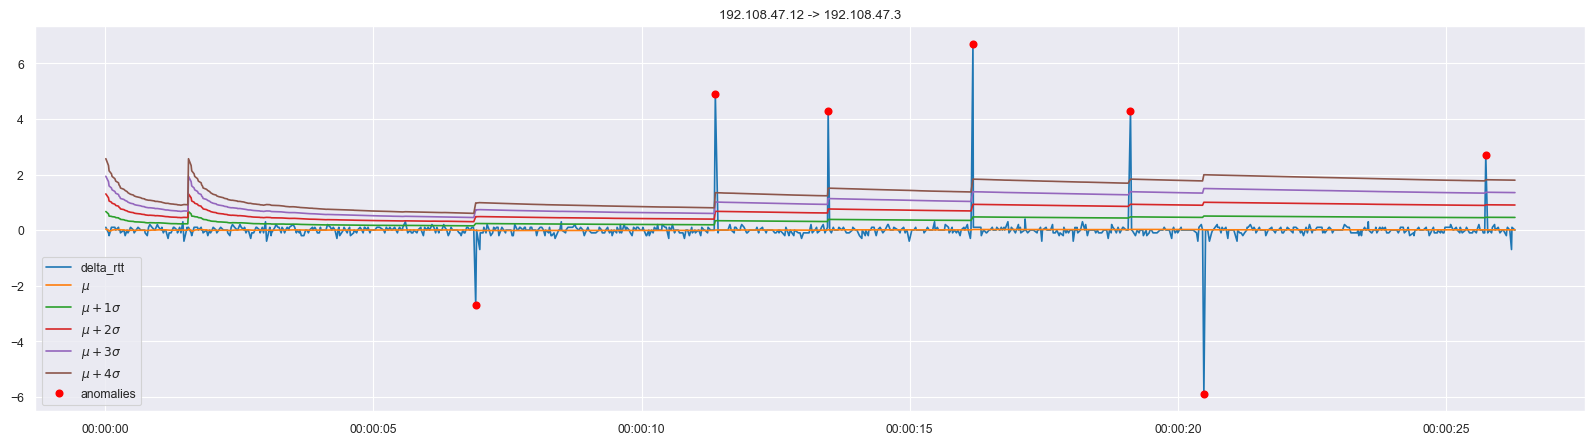

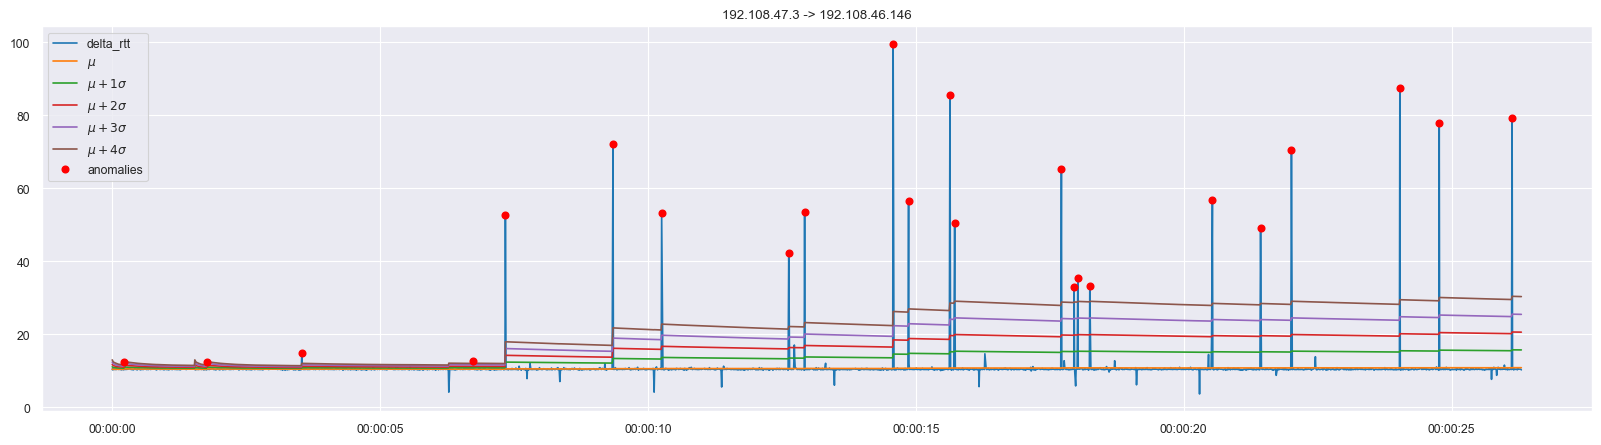

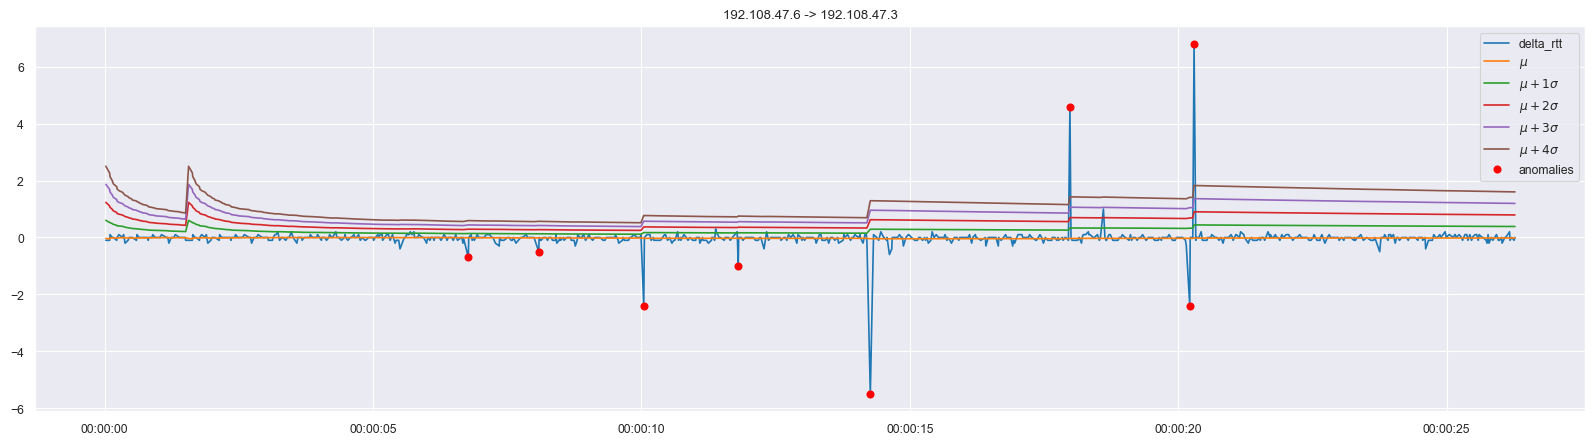

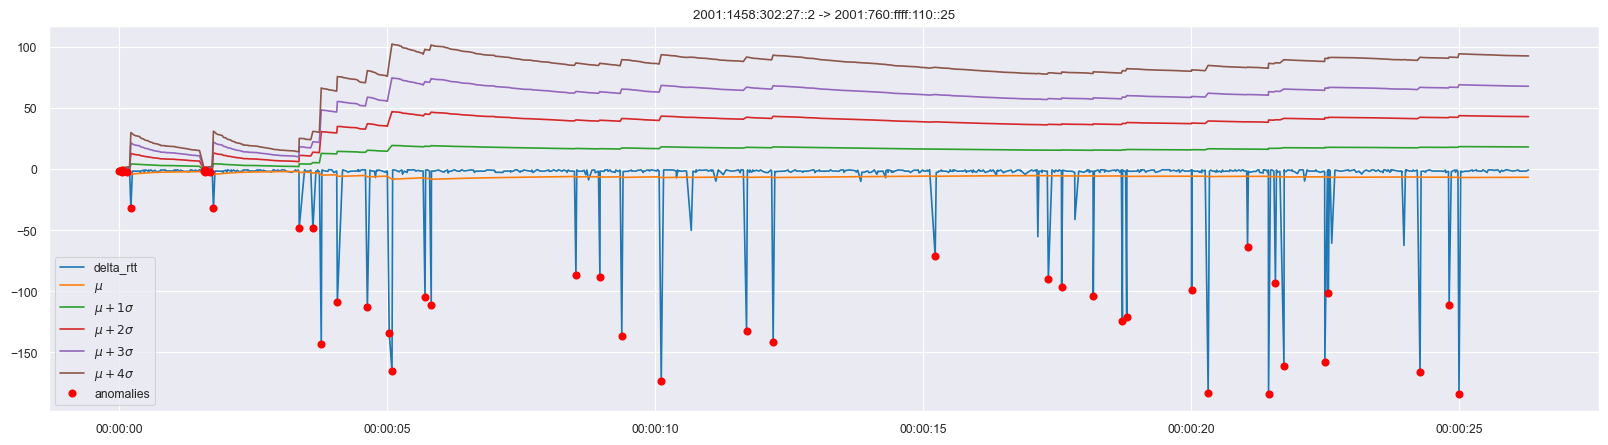

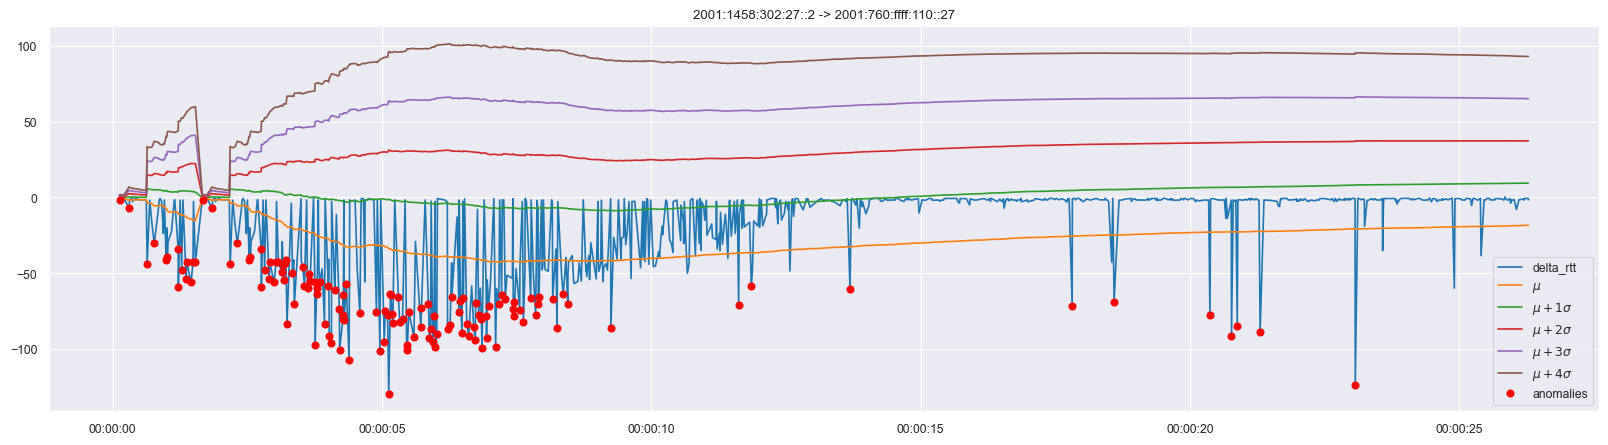

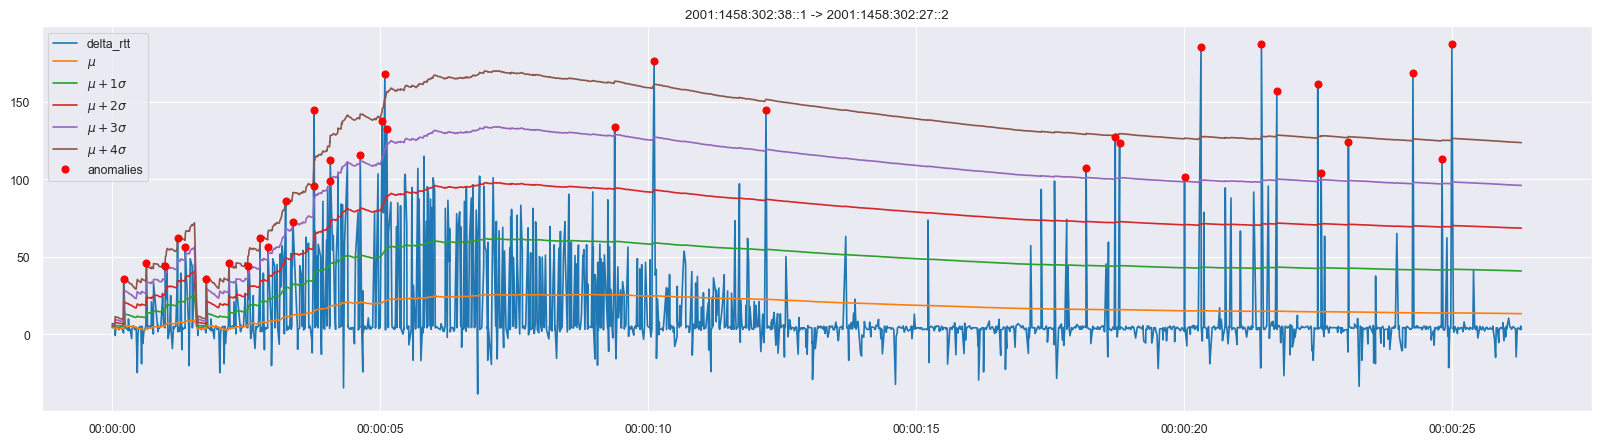

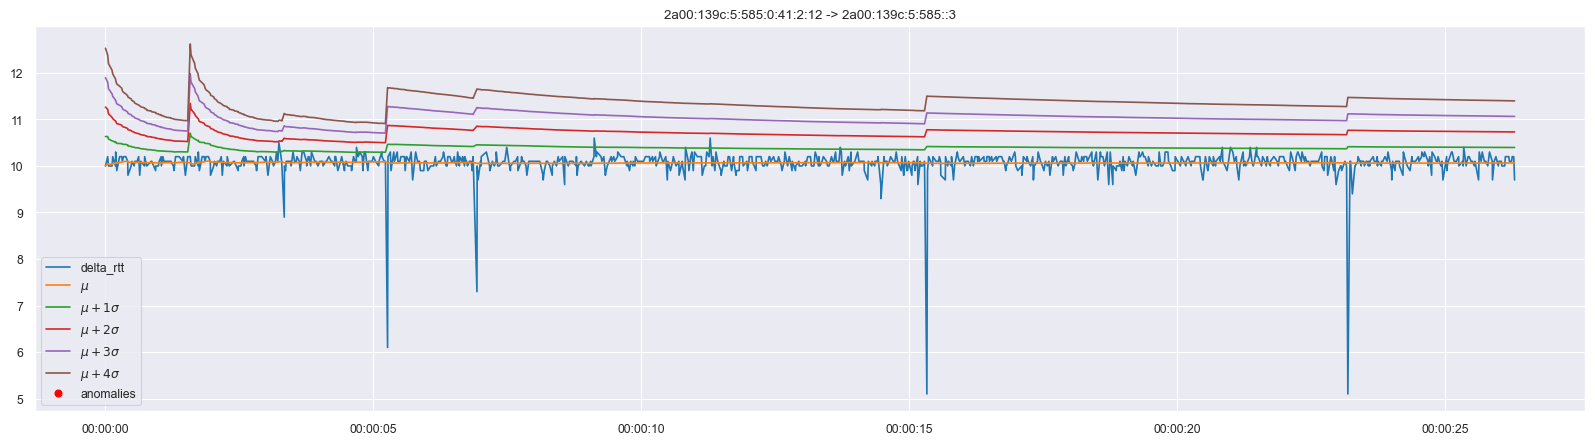

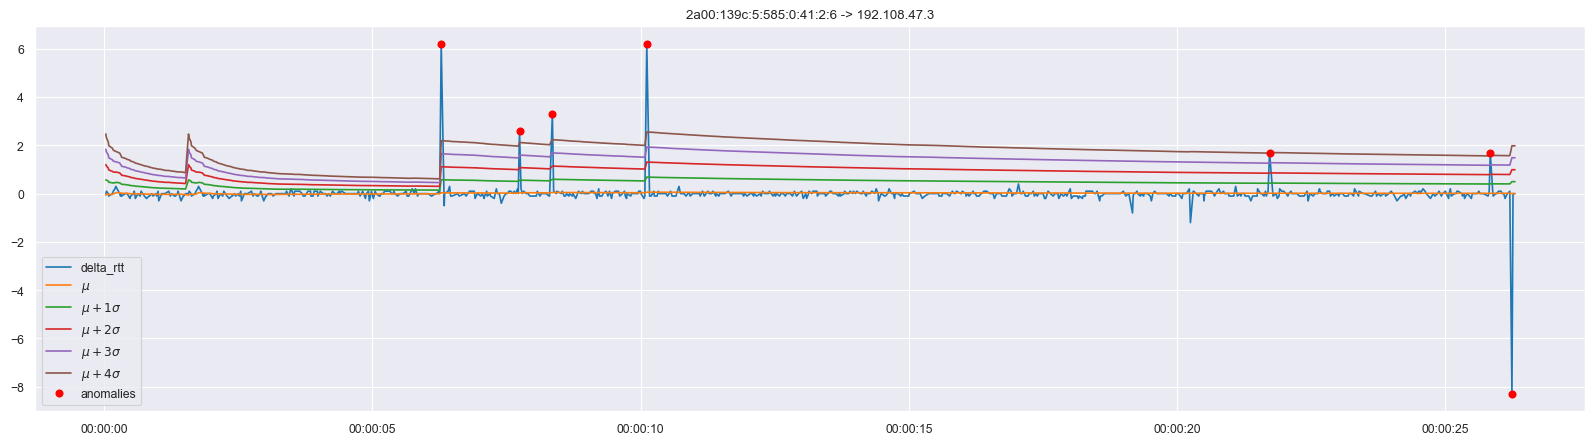

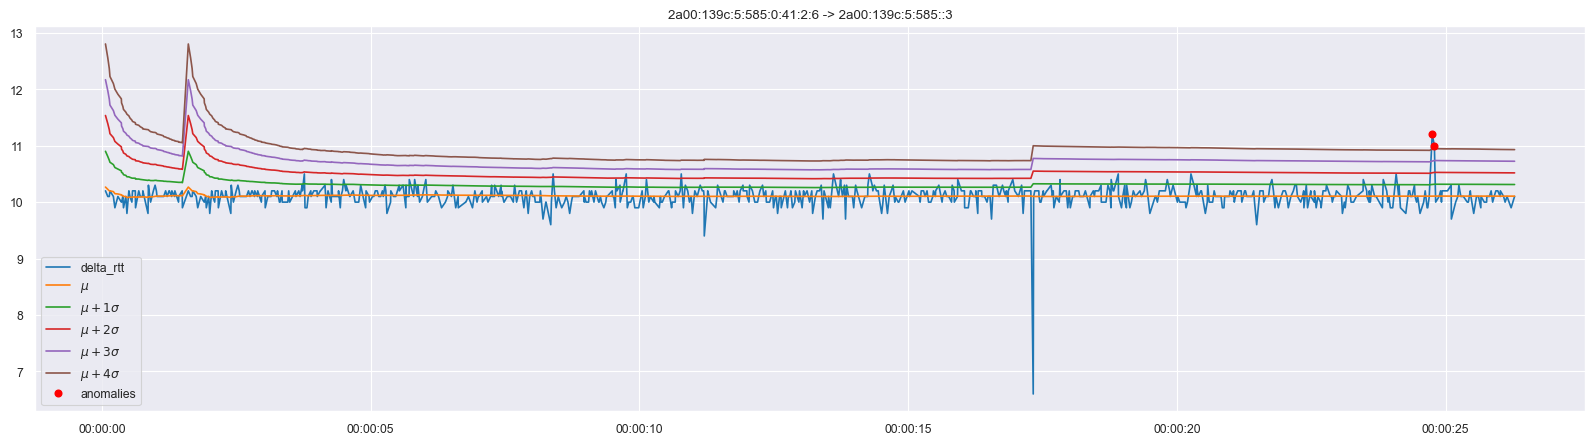

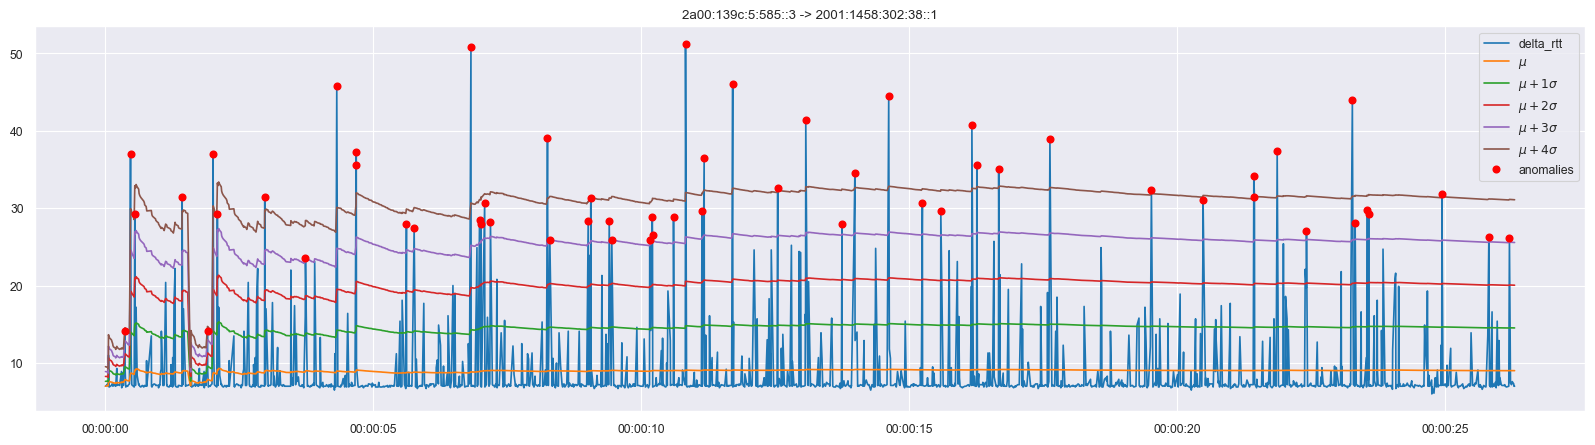

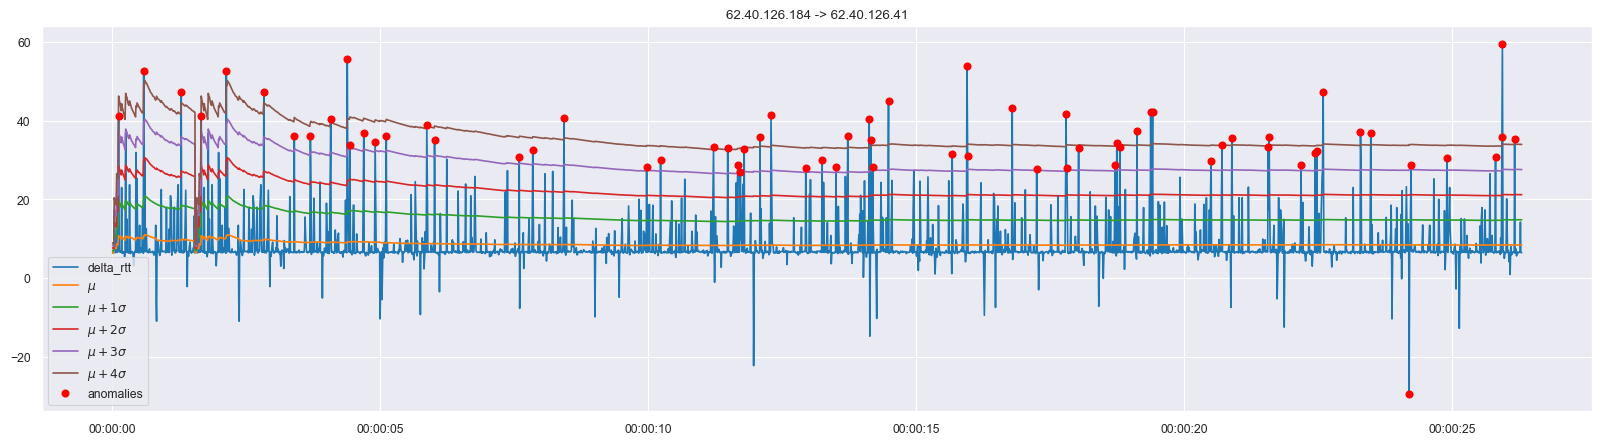

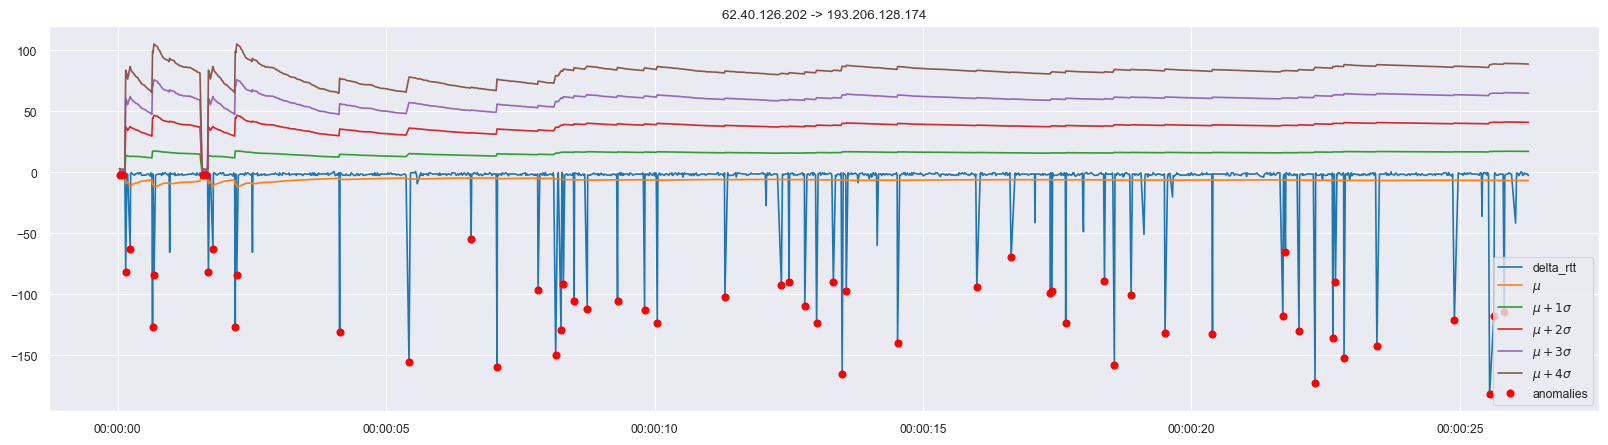

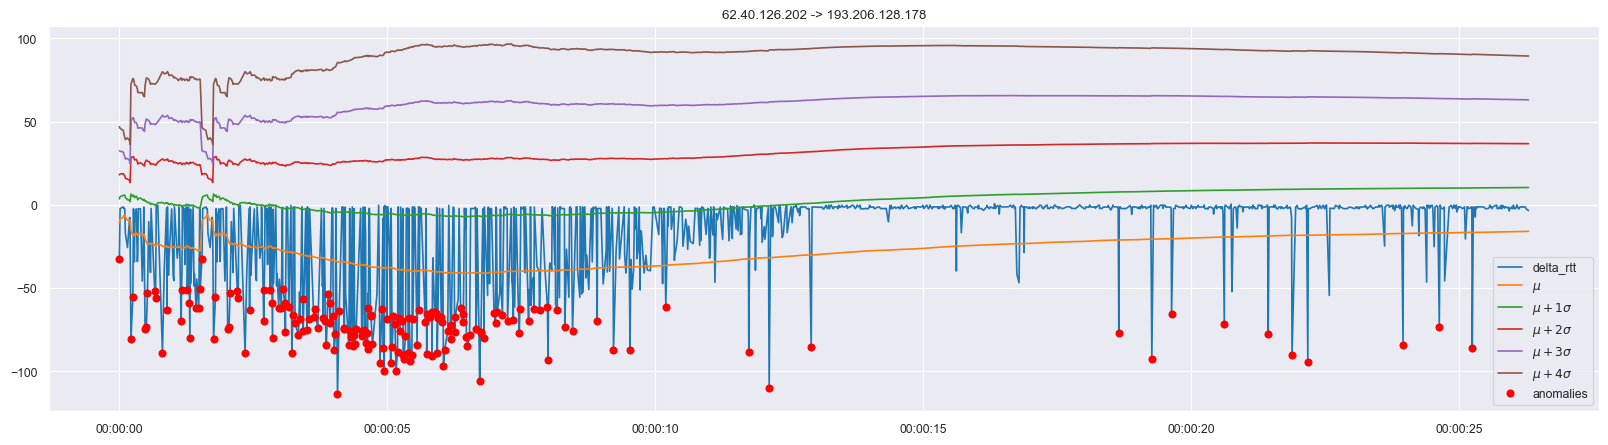

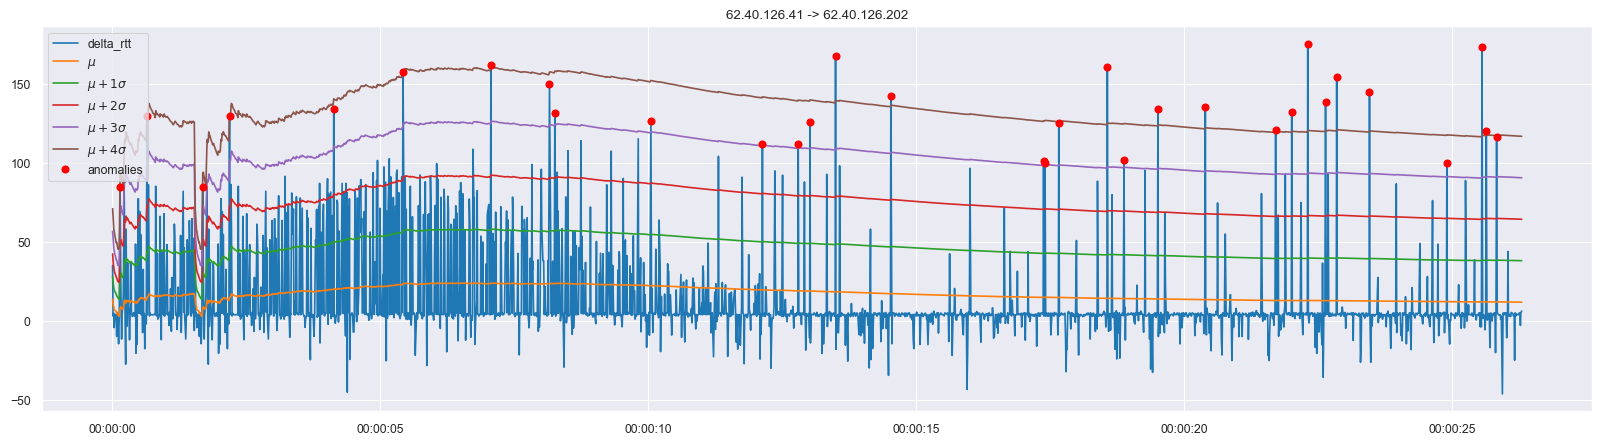

In [88]:
for i, x in evaluation_df.groupby(["src_node", "dest_node"]):
    if x.shape[0] < 1:
        continue
    # x = x.resample('10min').mean().dropna()
    fig = plt.figure(figsize=(20,5))
    plt.title(f"{i[0]} -> {i[1]}")

    plt.plot(x["delta_rtt"], label="delta_rtt")
    plt.plot(x["mu"], label="$\mu$")
    plt.plot(x["mu"] + 1*x["sigma"], label="$\\mu + 1 \\sigma$")
    plt.plot(x["mu"] + 2*x["sigma"],label="$\\mu + 2 \\sigma$")
    plt.plot(x["mu"] + 3*x["sigma"], label="$\\mu + 3 \\sigma$")
    plt.plot(x["mu"] + 4*x["sigma"], label="$\\mu + 4 \\sigma$")
    outliers = np.where(np.abs(x["delta_rtt"])> x["mu"] + 3*x["sigma"])
    plt.plot(x.index.values[outliers], x["delta_rtt"].values[outliers], marker="o", linestyle = 'None', color='r', label="anomalies")

    plt.legend()
    plt.show()

In [ ]:
path_stats.head()

In [ ]:
path_stats.index = pd.to_datetime(path_stats.index, unit='ms')

In [ ]:
path_stats

In [ ]:
for i, x in path_stats.groupby(["src", "dest"]):
    x[["markov_prob", "path_prob"]].plot(title="path probability",  figsize=(20,5))

In [ ]:
path_stats.index = pd.to_datetime(path_stats.index, unit='ms')

In [ ]:
i

In [ ]:
for i, x in path_stats.groupby(["src", "dest"]):
    # print(g.edges[i[0], i[1]])

    x.select_dtypes(exclude=['object']).rolling('15min').mean().plot(title=f"{i[0]} -> {i[1]}", y=["expected_rtt", "max_rtt"], figsize=(20,5))

# Explore the links

In [ ]:
stat_df.groupby(["src", "dest"]).size().sort_values(ascending=False).head(10)

In [ ]:
tmp = stat_df[(stat_df["src"] == "2a00:139c:5:585:0:41:2:6" ) & (stat_df["dest"] == "2001:760:4205:254::12")]
# 2001:760:4205:254::12

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
alarms = pd.read_json("data/alarms.json")

In [ ]:
alarms.index[0]

In [ ]:
alarms["created_at"] = pd.to_datetime(alarms["created_at"])

In [ ]:
alarms.set_index("created_at", inplace=True)

In [ ]:
idx = alarms["source"].apply(lambda x: "INFN-T1" in x and "FZK-LCG2" in x)#.index

In [ ]:
# convert timestamps to pd.DatetimeIndex
tmp.index = pd.DatetimeIndex(tmp.index)

In [ ]:
stat_df.head()

In [ ]:
fig=plt.figure()

tmp[["num_edges", "num_nodes"]].plot()
# plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index.intersection(idx.index), 0, 20, color="red")

In [ ]:
tmp.select_dtypes(exclude=['object']).diff().plot()

In [ ]:
# tmp["max_delta_rtts"], tmp["max_delta_ttls"]= tmp["max_delta_ttls"], tmp["max_delta_rtts"], 

In [ ]:
fig=plt.figure()
tmp.drop(columns=["num_edges", "num_nodes"]).corr()
# plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index, 2, 10, color="red")


In [ ]:
mean_ttls = tmp["max_delta_ttls"].mean()
std_ttls = tmp["max_delta_ttls"].std()
tmp["max_delta_ttls"].plot()
tmp[tmp["max_delta_ttls"]>mean_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='green')
tmp[tmp["max_delta_ttls"]>mean_ttls+ std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='blue')
tmp[tmp["max_delta_ttls"]>mean_ttls + 2*std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='orange')
tmp[tmp["max_delta_ttls"]>mean_ttls + 3*std_ttls]["max_delta_ttls"].plot(kind='line', marker='o', linestyle='None', color='red')

In [ ]:
mean_rtts = tmp["max_delta_rtts"].mean()
std_rtts = tmp["max_delta_rtts"].std()

tmp["max_delta_rtts"].plot()
tmp[tmp["max_delta_rtts"]>mean_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='green')
tmp[tmp["max_delta_rtts"]>mean_rtts + std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='blue')
tmp[tmp["max_delta_rtts"]>mean_rtts + 2*std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='orange')
tmp[tmp["max_delta_rtts"]>mean_rtts + 3*std_rtts]["max_delta_rtts"].plot(kind='line', marker='o', linestyle='None', color='red')

In [ ]:
tmp[["num_nodes", "num_edges"]].diff().plot()

In [ ]:
fig=plt.figure()
(tmp["num_edges"]/tmp[ "num_nodes"]).diff().plot()
# plt.vlines(alarms.loc[(alarms.index > tmp.index.min() ) & (alarms.index < tmp.index.max())].index, -0.0075, 0.0041, color="red")
plt.show()